In [0]:
from google.colab import files
uploaded = files.upload()

Saving TBBTs10repr.txt to TBBTs10repr.txt


In [0]:
import codecs
import pandas as pd
with codecs.open('TBBTs10repr.txt', 'r', encoding='utf-8', 
                 errors='ignore') as f:
                 data = pd.read_csv(f, delimiter=':', header = None)
data.head()

,0,1
0,Sheldon,You realize you and I could become brothers.
1,Leonard,We’re not gonna be brothers. We’re not gonna ...
2,Sheldon,I hope you’re right. ‘Cause a grown man livin...
3,Sheldon,Okay. Do you think your father’s doing unspea...
4,Sheldon,Are you saying that because the things are un...


In [0]:
data.to_csv('tbt10season')

In [0]:
data_tbt = pd.DataFrame()
data_tbt['label'] = data[0]
data_tbt['text'] = data[1]
data_tbt.head()

,label,text
0,Sheldon,You realize you and I could become brothers.
1,Leonard,We’re not gonna be brothers. We’re not gonna ...
2,Sheldon,I hope you’re right. ‘Cause a grown man livin...
3,Sheldon,Okay. Do you think your father’s doing unspea...
4,Sheldon,Are you saying that because the things are un...


In [0]:
data_tbt.describe

<bound method NDFrame.describe of         label                                               text
0     Sheldon       You realize you and I could become brothers.
1     Leonard   We’re not gonna be brothers. We’re not gonna ...
2     Sheldon   I hope you’re right. ‘Cause a grown man livin...
3     Sheldon   Okay. Do you think your father’s doing unspea...
4     Sheldon   Are you saying that because the things are un...
...       ...                                                ...
1289  Sheldon   If you find this draft acceptable, then I bel...
1290    Penny   Article 8, subsection B, Leonard will restric...
1291  Leonard   Article 10, subsection C, if questioned Penny...
1292  Sheldon   Oh well, great then, here, you sign here, dat...
1293  Sheldon   Mm. You seem to be forgetting the no nostalgi...

[1294 rows x 2 columns]>

In [0]:
from spacy.lang.en.stop_words import STOP_WORDS
import re
import spacy

In [0]:
nlp = spacy.load('en',disable=['parser', 'ner', 'textcat'])

def reduce_to_double_max(text):
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
    return re.sub(r'(\W)\1+', r'\1', text)
def preprocess_corpus(corpus):
    data_pro = []
    data_ = []
    corpus = (reduce_to_double_max(s.lower()) for s in corpus)
    docs = nlp.pipe(corpus, batch_size=1000, n_threads=4)
    return [[x.lemma_ for x in doc if x.is_alpha and not x.is_stop] for doc in docs]

In [0]:
data_pro = preprocess_corpus(data_tbt['text'])
data_tbt['text'] = data_pro

In [0]:
token_len = []
for i in data_tbt['text']:
    token_len.append(len(i))
data_tbt['token_number'] = token_len

In [0]:
whole_verb = []
for i in data_tbt['text']:
    verbs = []
    doc = nlp(' '.join(i))
    for s in doc:
        verbs.append(s.pos_)
    whole_verb.append(verbs)
verb_count = []
for i, x in enumerate(whole_verb):
    verb_count.insert(i, x.count('VERB'))
data_tbt['verb_number'] = verb_count

In [0]:
import numpy as np
vecs = pd.DataFrame(index = data_tbt.index, columns = [d for d in range(96)])
for i, t in enumerate(data_tbt['text']): # для каждой строки в датафрейме
    t_vec = (nlp(' '.join(t))).vector # векторизуем текст
    if t_vec.shape == (0,):
        vecs.values[i] = np.array(0)*96 # заменяем строчки на наш вектор
    else:
        vecs.values[i] = t_vec

In [0]:
data_new = pd.concat([data_tbt.drop(['text'], axis = 1), vecs], axis=1)
data_new.head()

,label,token_number,verb_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,Sheldon,2,0,-1.35912,-0.989591,-0.104039,-1.1276,1.44544,1.46907,-0.59236,1.13845,1.24987,1.62301,3.30415,-0.419429,2.68376,-0.180989,-0.204861,-0.684118,0.857609,1.05924,-1.91501,0.261786,-0.665632,-0.966937,-0.0179818,0.190427,-2.1968,-2.9175,1.86705,-0.977872,1.62183,-1.25272,1.88203,-0.490528,-0.498273,-2.08212,-0.0349176,-2.90411,2.18764,...,1.06282,2.21492,2.03157,0.199715,1.33145,-1.92948,0.877319,-0.498339,1.83412,0.11936,1.41421,-1.50732,-1.22018,1.21628,-0.0193288,1.18228,1.02507,1.16047,-2.9757,-0.142642,-0.222469,0.0560156,-1.86014,1.00273,1.27129,-0.671182,0.484192,-1.63805,-0.432557,2.6526,-0.725841,-1.02705,-1.49847,-1.48066,2.43371,0.8494,-2.03987,3.66849,-0.251989,-0.257596
1,Leonard,7,2,-1.1586,0.461712,-0.57514,-1.50362,0.144259,1.59457,-0.68178,0.938731,2.25674,3.7008,1.39988,-0.863941,1.60122,-0.25668,-0.512089,0.134678,0.591552,-0.364361,-1.81352,-0.47505,0.00698246,1.31006,-0.800213,-0.498816,-0.701418,-0.481893,1.20067,0.20573,1.21968,-2.11486,1.87781,-0.590945,-0.494286,-0.551039,0.247099,-1.50696,0.62343,...,1.47809,0.0625001,0.54193,-0.163464,2.95678,-1.49394,1.44358,-1.28215,-0.622607,-1.67779,2.40044,1.31933,-1.30568,0.921301,0.255938,2.08978,-0.60309,-0.288577,-2.00134,-0.277255,0.868758,0.12926,-0.541282,0.904867,0.561075,-0.579279,-0.0749008,0.446291,0.605268,0.706811,0.478425,-0.190074,-0.7999,-1.18076,0.16411,-1.83851,-1.38154,0.219031,-0.868492,0.580945
2,Sheldon,10,2,0.559066,-0.0453554,-1.4974,-0.000272787,1.34779,1.97274,-0.43426,1.74321,1.65,2.44734,1.09579,-1.05055,2.73522,-0.563267,-0.504252,-0.442305,0.0849331,0.297745,-1.30424,-1.24976,1.32591,-1.13348,-0.0732787,-0.530197,-1.43209,-0.563651,-0.429123,-2.20949,3.23162,-1.19779,0.471085,-0.426747,-0.492798,-0.690385,-0.475061,-1.04208,2.7063,...,0.97832,1.72018,-0.381751,-0.126511,1.89304,-0.46588,-0.685478,-0.0541555,0.555933,-0.654077,1.59842,-1.94893,-0.0407614,1.54631,-0.23773,0.390536,-0.683272,-0.720386,-1.41567,-1.45257,0.84128,0.209728,-0.666683,0.823034,0.904415,-1.1642,-0.481422,-0.295444,1.35273,1.87943,-0.325215,-0.838157,-0.990656,0.017527,2.15297,0.299266,-1.59763,2.28802,0.883281,0.360921
3,Sheldon,6,1,-1.01056,-0.820397,-1.66702,-0.315195,1.83765,1.53629,-0.10272,1.3669,1.26525,1.96768,0.501702,-1.08685,2.238,-0.268875,0.158822,0.547045,0.329489,1.056,-0.961372,-0.771,-0.376726,-0.557453,-0.891509,-0.182689,-0.184529,0.771187,0.368562,-2.1066,2.24716,-1.20771,-0.523347,-0.229848,0.354541,-0.638458,-0.314767,-0.935505,1.74597,...,0.494573,1.50939,0.120714,-0.378213,1.41812,-1.36363,-0.507804,0.490459,1.52058,-0.799559,-0.0926176,-1.68623,-1.11412,-0.00171745,-0.617486,0.218995,-0.42871,1.46284,-1.36474,-1.56504,0.701289,0.0600222,-0.827749,1.70647,0.856113,-1.31398,0.235889,0.273486,0.847479,1.26066,-0.00337345,-0.737218,-0.623382,0.389851,1.12208,0.375718,-1.09765,2.90842,1.24455,-0.390777
4,Sheldon,3,1,-0.426308,0.276309,0.256766,-1.18564,1.68355,0.755702,0.59754,3.03525,2.28857,2.22038,0.0779524,-1.23499,1.35462,-1.11516,1.1506,0.44546,-0.285483,1.43268,-0.967302,-0.884867,-0.441625,-0.484363,-1.35572,-0.483504,0.0730076,0.326705,-0.479417,-2.3624,1.33856,-0.115821,0.0796312,0.455551,1.31852,0.918931,-0.806214,-2.08068,3.19673,...,1.28677,0.380409,-0.111971,-0.47132,3.15272,-1.54872,-1.14522,-0.63841,1.03892,-1.43371,1.3236,-0.855151,-1.28327,-0.742945,-0.875302,1.1421,0.984488,1.24695,-1.79197,-0.20175,0.49855,-0.266859,-0.758239,2.46038,0.662435,-1.6397,1.24046,0.289033,-0.309713,1.05037,-0.560489,-1.23893,0.286168,-0.666675,0.887993,-0.419051,-1.83017,2.6685,0.413843,0.270734


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_new.drop(['label'], axis = 1), data_new['label'], test_size=0.33, random_state=42)

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_train)
train_class = encoder.transform(y_train)
test_class = encoder.transform(y_test)
dict(enumerate(encoder.classes_))

{0: 'Howard', 1: 'Leonard', 2: 'Penny', 3: 'Raj', 4: 'Sheldon'}

In [0]:
from sklearn import svm
from sklearn import metrics

clf = svm.SVC(kernel='linear') # Linear Kernel
clf.fit(x_train, train_class)
y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(test_class, y_pred))
print("Precision:",metrics.precision_score(test_class, y_pred, average='macro'))
print("Recall:",metrics.recall_score(test_class, y_pred, average='macro'))

Accuracy: 0.3177570093457944
Precision: 0.2629264306713329
Recall: 0.2577410979103246


In [0]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, train_class)
y_pred_log=logreg.predict(x_test)
cnf_matrix = metrics.confusion_matrix(test_class, y_pred_log)
cnf_matrix

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[ 6,  8, 10,  7, 31],
       [ 5, 15, 12,  6, 45],
       [12, 11, 20,  7, 35],
       [ 5,  9,  5,  8, 26],
       [10, 22, 10, 10, 93]])

In [0]:
print("Accuracy:",metrics.accuracy_score(test_class, y_pred_log))
print("Precision:",metrics.precision_score(test_class, y_pred_log, average='macro'))
print("Recall:",metrics.recall_score(test_class, y_pred_log, average='macro'))

Accuracy: 0.3317757009345794
Precision: 0.2708830604940445
Recall: 0.2610227818665907


Text(0.5, 257.44, 'Predicted label')

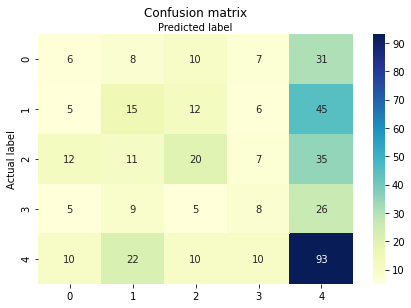

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

class_names= list(dict(enumerate(encoder.classes_)).values()) # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(dict(enumerate(encoder.classes_))))
plt.xticks(tick_marks, list(dict(enumerate(encoder.classes_)).values()))
plt.yticks(tick_marks, list(dict(enumerate(encoder.classes_)).values()))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [0]:
from sklearn.ensemble import RandomForestClassifier


rdf=RandomForestClassifier(n_estimators=50)
rdf.fit(x_train, train_class)
y_pred_rnf=rdf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(test_class, y_pred_rnf))
print("Precision:",metrics.precision_score(test_class, y_pred_rnf, average='macro'))
print("Recall:",metrics.recall_score(test_class, y_pred_rnf, average='macro'))

Accuracy: 0.35514018691588783
Precision: 0.2766070791953145
Recall: 0.24841025967650682


In [0]:
data_string = []
for i in data_tbt['text']:
  data_string.append(' '.join(i))
data_tbt_string = pd.DataFrame()
data_tbt_string['label'] = data_tbt['label']
data_tbt_string['text'] = data_string
data_tbt_string['token_number'] = data_tbt['token_number']
data_tbt_string['verb_number'] = data_tbt['verb_number']
data_tbt_string.head()

,label,text,token_number,verb_number
0,Sheldon,realize brother,2,0
1,Leonard,go to brother go to stepbrother sleep,7,2
2,Sheldon,hope right cause grown man live brother brothe...,10,2
3,Sheldon,okay think father unspeakable thing mother,6,1
4,Sheldon,say thing unspeakable,3,1


In [0]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(data_tbt_string.drop(['label'], axis = 1), data_tbt_string['label'], test_size=0.33, random_state=42)

In [0]:
encoder.fit(y_train_1)
train_class_1 = encoder.transform(y_train_1)
test_class_1 = encoder.transform(y_test_1)
dict(enumerate(encoder.classes_))

{0: 'Howard', 1: 'Leonard', 2: 'Penny', 3: 'Raj', 4: 'Sheldon'}

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect_1 = TfidfVectorizer(max_df=0.87,
               smooth_idf=1, max_features=300000)
#tf-idf
train_tf =  vect_1.fit_transform(x_train_1['text'])
test_tf = vect_1.transform(x_test_1['text'])

In [0]:
logreg = LogisticRegression()
logreg.fit(train_tf, train_class_1)
y_pred_log_1=logreg.predict(test_tf)
print("Accuracy:",metrics.accuracy_score(test_class_1, y_pred_log_1))
print("Precision:",metrics.precision_score(test_class_1, y_pred_log_1, average='macro'))
print("Recall:",metrics.recall_score(test_class_1, y_pred_log_1, average='macro'))
print("F1-score:",metrics.f1_score(test_class_1, y_pred_log_1, average='macro'))

Accuracy: 0.37383177570093457
Precision: 0.28050580179068174
Recall: 0.25177515361204444
F1-score: 0.20787672573671304


In [0]:
clf_1 = svm.SVC(kernel='linear') # Linear Kernel
clf_1.fit(train_tf, train_class_1)
y_pred_1 = clf_1.predict(test_tf)
print("Accuracy:",metrics.accuracy_score(test_class_1, y_pred_1))
print("Precision:",metrics.precision_score(test_class_1, y_pred_1, average='macro'))
print("Recall:",metrics.recall_score(test_class_1, y_pred_1, average='macro'))

Accuracy: 0.352803738317757
Precision: 0.2568019943019943
Recall: 0.2479436674003331


In [0]:
rdf_1 = RandomForestClassifier(n_estimators=50)
rdf_1.fit(train_tf, train_class_1)
y_pred_rnf_1 = rdf_1.predict(test_tf)
print("Accuracy:",metrics.accuracy_score(test_class_1, y_pred_rnf_1))
print("Precision:",metrics.precision_score(test_class, y_pred_rnf_1, average='macro'))
print("Recall:",metrics.recall_score(test_class, y_pred_rnf_1, average='macro'))

Accuracy: 0.34345794392523366
Precision: 0.2428681971771597
Recall: 0.24326550157722196


In [0]:
pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.7MB/s 
     |████████████████████████████████| 552kB 21.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=f4e8090603275e9cce2d2f44b1d67f68ad3ee4a048713a3bc16bf5c89d12dfca
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=588354f190069ce8ffc0cdb7014c9c262dafee9b9405e727076c46e15f5804a6
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import logging
import warnings

warnings.filterwarnings('ignore', category = DeprecationWarning)

In [0]:
text_data = data_pro
id2word = corpora.Dictionary(text_data)
texts = text_data
corpus = [id2word.doc2bow(text) for text in texts]

In [0]:
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics = 5, id2word=id2word, passes=15)
topics = lda_model.print_topics(num_words=6)
for t in topics:
    print(t)

(0, '0.022*"get" + 0.017*"know" + 0.017*"good" + 0.012*"oh" + 0.011*"like" + 0.010*"want"')
(1, '0.026*"know" + 0.017*"go" + 0.014*"come" + 0.012*"want" + 0.010*"like" + 0.010*"people"')
(2, '0.027*"go" + 0.023*"like" + 0.021*"think" + 0.021*"oh" + 0.019*"know" + 0.015*"hey"')
(3, '0.018*"oh" + 0.015*"know" + 0.010*"like" + 0.009*"need" + 0.009*"great" + 0.008*"love"')
(4, '0.017*"feel" + 0.016*"oh" + 0.013*"baby" + 0.010*"people" + 0.009*"think" + 0.008*"look"')


In [0]:
pyLDAvis.enable_notebook()
showme = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
showme

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.034328  0.111842       1        1  24.097853
4     -0.093449  0.046020       2        1  22.764605
0      0.000377 -0.033607       3        1  19.423677
1     -0.064599 -0.084067       4        1  18.751520
2      0.123343 -0.040187       5        1  14.962353, topic_info=    Category        Freq     Term       Total  loglift  logprob
2    Default   89.000000       go   89.000000  30.0000  30.0000
5    Default   42.000000       to   42.000000  29.0000  29.0000
18   Default   75.000000    think   75.000000  28.0000  28.0000
182  Default   45.000000     good   45.000000  27.0000  27.0000
52   Default  115.000000       oh  115.000000  26.0000  26.0000
..       ...         ...      ...         ...      ...      ...
97    Topic5    4.816861       uh   29.140892   0.0996  -5.4458
348   Topic5    4.122560  sheldon   29.929115  -0.0827  -5.6015
164   Topic5    3.967694     time   32.299229  -0.1972  -5.6398
94    Topic5    3.903135     tell   33.969376  -0.2640  -5.6562
103   Topic5    3.841675     year   12.956270   0.6840  -5.6720

[363 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
833       5  0.671734  accept
1392      5  0.892803     act
922       4  0.875819      ah
390       1  0.260914     amy
390       2  0.149094     amy
...     ...       ...     ...
103       4  0.231548    year
103       5  0.308731    year
122       3  0.366045     yes
122       4  0.439254     yes
122       5  0.146418     yes

[577 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 2, 3])

In [0]:
print('Perplexity: ', lda_model.log_perplexity(corpus))

Perplexity:  -7.611392152664438


In [0]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.38793565695696597


In [0]:
data_tbt.head()

,label,text,token_number,verb_number
0,Sheldon,"[realize, brother]",2,0
1,Leonard,"[go, to, brother, go, to, stepbrother, sleep]",7,2
2,Sheldon,"[hope, right, cause, grown, man, live, brother...",10,2
3,Sheldon,"[okay, think, father, unspeakable, thing, mother]",6,1
4,Sheldon,"[say, thing, unspeakable]",3,1


In [0]:
dict_lda = {}
for i in dict(enumerate(encoder.classes_)).values():
  dict_lda[i] = []
dict_lda

{'Howard': [], 'Leonard': [], 'Penny': [], 'Raj': [], 'Sheldon': []}

In [0]:
for x, y in enumerate(data_tbt['text']):
  dict_lda[data_tbt['label'][x]].append(y)

In [0]:
dict_viz = {}
for i in dict_lda:
  text_data = dict_lda[i]
  id2word = corpora.Dictionary(text_data)
  texts = text_data
  corpus = [id2word.doc2bow(text) for text in texts]
  lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=id2word, passes=15)
  dict_viz[i] = [lda_model, corpus, id2word]
  topics = lda_model.print_topics(num_words=5)
  print('Topics of', i)
  for t in topics:
    print(t)

Topics of Howard
(0, '0.021*"like" + 0.019*"oh" + 0.014*"get" + 0.012*"know" + 0.012*"say"')
(1, '0.026*"think" + 0.026*"know" + 0.013*"dibba" + 0.012*"want" + 0.011*"go"')
(2, '0.024*"baby" + 0.017*"go" + 0.014*"to" + 0.013*"oh" + 0.010*"room"')
Topics of Leonard
(0, '0.023*"oh" + 0.016*"sheldon" + 0.016*"get" + 0.012*"like" + 0.011*"know"')
(1, '0.016*"come" + 0.015*"thing" + 0.012*"like" + 0.012*"know" + 0.012*"good"')
(2, '0.032*"go" + 0.015*"to" + 0.014*"need" + 0.012*"tell" + 0.012*"know"')
Topics of Penny
(0, '0.042*"know" + 0.023*"tell" + 0.017*"okay" + 0.017*"like" + 0.014*"leonard"')
(1, '0.035*"oh" + 0.031*"go" + 0.021*"to" + 0.017*"like" + 0.013*"think"')
(2, '0.018*"get" + 0.014*"need" + 0.012*"hey" + 0.012*"ask" + 0.012*"okay"')
Topics of Raj
(0, '0.032*"oh" + 0.022*"go" + 0.019*"like" + 0.019*"know" + 0.016*"think"')
(1, '0.020*"come" + 0.015*"oh" + 0.015*"think" + 0.013*"bernadette" + 0.013*"good"')
(2, '0.016*"like" + 0.015*"yeah" + 0.011*"know" + 0.011*"guy" + 0.011*"

In [0]:
pyLDAvis.enable_notebook()
showme = pyLDAvis.gensim.prepare(dict_viz['Howard'][0], dict_viz['Howard'][1], dict_viz['Howard'][2])
showme

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.010416 -0.091405       1        1  34.719913
2     -0.088097  0.053355       2        1  33.693241
1      0.098513  0.038050       3        1  31.586847, topic_info=    Category       Freq     Term      Total  loglift  logprob
58   Default   7.000000     want   7.000000  30.0000  30.0000
85   Default   5.000000      say   5.000000  29.0000  29.0000
159  Default   9.000000     baby   9.000000  28.0000  28.0000
519  Default   4.000000    dibba   4.000000  27.0000  27.0000
84   Default  10.000000     like  10.000000  26.0000  26.0000
..       ...        ...      ...        ...      ...      ...
207   Topic3   2.754674     good   6.469406   0.2986  -4.7380
168   Topic3   2.131236    great   4.520067   0.4006  -4.9946
14    Topic3   4.032158     know  14.289930  -0.1128  -4.3570
41    Topic3   1.499497  meeting   3.229688   0.3852  -5.3462
174   Topic3   1.481980      sex   2.574588   0.6001  -5.3579

[181 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
159       1  0.311669  baby
159       3  0.727228  baby
40        1  0.770387   bad
40        3  0.385193   bad
399       1  1.020450   big
...     ...       ...   ...
12        1  0.306525  yeah
12        2  0.459788  yeah
12        3  0.153263  yeah
24        1  0.382620   yes
24        2  0.765239   yes

[198 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [0]:
from google.colab import files
uploaded = files.upload()

Saving send_M_crag.csv to send_M_crag.csv


In [0]:
import pandas as pd

data_ep = pd.read_csv('send_M_crag.csv', delimiter=';')
data_ep.head()

,Unnamed: 0,label,text,serie
0,0,Sheldon,You realize you and I could become brothers.,1
1,1,Leonard,We’re not gonna be brothers. We’re not gonna ...,1
2,2,Sheldon,I hope you’re right. ‘Cause a grown man livin...,1
3,3,Sheldon,Okay. Do you think your father’s doing unspea...,1
4,4,Sheldon,Are you saying that because the things are un...,1


In [0]:
del data_ep['Unnamed: 0']

In [0]:
data_ep.head()

,label,text,serie
0,Sheldon,You realize you and I could become brothers.,1
1,Leonard,We’re not gonna be brothers. We’re not gonna ...,1
2,Sheldon,I hope you’re right. ‘Cause a grown man livin...,1
3,Sheldon,Okay. Do you think your father’s doing unspea...,1
4,Sheldon,Are you saying that because the things are un...,1


In [0]:
data_pro_ep = preprocess_corpus(data_ep['text'])
data_ep['text'] = data_pro_ep
token_len_ep = []
for i in data_ep['text']:
    token_len_ep.append(len(i))
data_ep['token_number'] = token_len_ep
data_ep.head()

,label,text,serie,token_number
0,Sheldon,"[realize, brother]",1,2
1,Leonard,"[go, to, brother, go, to, stepbrother, sleep]",1,7
2,Sheldon,"[hope, right, cause, grown, man, live, brother...",1,10
3,Sheldon,"[okay, think, father, unspeakable, thing, mother]",1,6
4,Sheldon,"[say, thing, unspeakable]",1,3


In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(data_ep['label'])
all_class = encoder.transform(data_ep['label'])
dict(enumerate(encoder.classes_))

{0: 'Howard', 1: 'Leonard', 2: 'Penny', 3: 'Raj', 4: 'Sheldon'}

In [0]:
data_ep.columns

Index(['label', 'text', 'serie ', 'token_number'], dtype='object')

In [0]:
dict_ep = {}
for i in dict(enumerate(encoder.classes_)).values():
  dict_ep[i] = [0]*data_ep['serie '].nunique()

In [0]:
for x, y in enumerate(data_ep['token_number']):
  dict_ep[data_ep['label'][x]][data_ep['serie '][x]-1] += y

In [0]:
words_ = 0
for i in data_ep['token_number']:
  words_ += i
words_

7462

In [0]:
dict_ep

{'Howard': [63, 112, 43, 48, 114, 142, 83, 25, 79, 42, 99, 42, 104],
 'Leonard': [64, 72, 98, 134, 101, 100, 135, 30, 135, 115, 66, 107, 147],
 'Penny': [126, 154, 57, 94, 128, 48, 87, 25, 54, 59, 85, 98, 129],
 'Raj': [65, 63, 133, 25, 44, 44, 33, 206, 47, 69, 149, 18, 74],
 'Sheldon': [180, 195, 190, 295, 217, 236, 288, 246, 313, 218, 207, 246, 217]}

In [0]:
ddd = []
for i in dict_lda['Howard']:
  ddd.append(' '.join(i))
' '.join(ddd)

'maybe traffic ticket hey think secret government agent chase make lunatic yeah okay performance anxiety people know yes hello uh howard wolowitz colonel richard williams hi colonel williams help oh uh yes india know immigration status relax hold speaking okay sure meet thursday caltech fine yeah ask colonel meeting bad news calm try think bother talk know invention away point story yell change air force contact quantum gyroscope want meeting happen able sell commercially count money need wife try hard bed oh yeah think stay thin sheldon contribute weapon system oppress mankind thousand year know maybe meeting talk lawyer jewish like say hey indian cousin work centre cousin lawyer second cousin boca raton well fort lauderdale importantly last day jeopardy clearly smart guy marry little catholic girl leonard sheldon come guidance system like say e mail meeting thursday advice group effort guess pick main brain thank know little concerned weapon maybe know work hour day seven day week lo

In [0]:
heroes = {}
for i in dict_lda:
  record = []
  for s in dict_lda[i]:
    record.append(' '.join(s))
  heroes[i] = ' '.join(record)
heroes

{'Howard': 'maybe traffic ticket hey think secret government agent chase make lunatic yeah okay performance anxiety people know yes hello uh howard wolowitz colonel richard williams hi colonel williams help oh uh yes india know immigration status relax hold speaking okay sure meet thursday caltech fine yeah ask colonel meeting bad news calm try think bother talk know invention away point story yell change air force contact quantum gyroscope want meeting happen able sell commercially count money need wife try hard bed oh yeah think stay thin sheldon contribute weapon system oppress mankind thousand year know maybe meeting talk lawyer jewish like say hey indian cousin work centre cousin lawyer second cousin boca raton well fort lauderdale importantly last day jeopardy clearly smart guy marry little catholic girl leonard sheldon come guidance system like say e mail meeting thursday advice group effort guess pick main brain thank know little concerned weapon maybe know work hour day seven 

In [0]:
from collections import Counter
import re

In [0]:
for key, value in heroes.items():
  cnt = Counter(x for x in re.findall(r'[a-z\']{2,}', value))
  print(key, cnt.most_common(10))

Howard [('know', 21), ('go', 18), ('think', 16), ('oh', 16), ('like', 15), ('baby', 14), ('to', 12), ('maybe', 11), ('okay', 11), ('want', 10)]
Leonard [('go', 28), ('know', 22), ('oh', 22), ('like', 21), ('sheldon', 21), ('want', 15), ('think', 14), ('to', 13), ('good', 13), ('thing', 12)]
Penny [('know', 31), ('oh', 29), ('like', 25), ('go', 20), ('okay', 20), ('yeah', 17), ('get', 15), ('to', 14), ('tell', 14), ('leonard', 14)]
Raj [('oh', 26), ('think', 20), ('know', 20), ('like', 20), ('come', 15), ('okay', 14), ('go', 13), ('baby', 12), ('guy', 10), ('good', 10)]
Sheldon [('know', 75), ('oh', 57), ('like', 44), ('go', 35), ('think', 33), ('right', 28), ('amy', 26), ('want', 23), ('leonard', 22), ('people', 22)]
